# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

pd.set_option('display.max_rows', None)

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Import dataset
# data = pd.read_csv('/content/drive/MyDrive/Erdos Bootcamp May 2022/Project/CoverMyMeds Project/pharmacy_tx.csv')
data = pd.read_csv('C:/Users/diego/Google Drive/Erdos Bootcamp May 2022/Project/CoverMyMeds Project/data.csv')

In [3]:
# Fill all NaN with NA. They are all located in PCN and GROUP columns. Keep NA as a different category.
data = data.fillna('NA')

In [4]:
# Set type of all features to save memory
data = data.astype({'tx_date':'datetime64[ns]', 
                    'month_name': 'category', 
                    'day_name': 'category', 
                    'pharmacy': 'category', 
                    'bin_pcn_group': 'category', 
                    'bin': 'category', 
                    'pcn': 'category', 
                    'group': 'category',
                    'drug_brand': 'category',
                    'drug_name': 'category',
                    'diag_letter': 'category',
                    'diag_num1': 'category',
                    'diag_num2': 'category',
                    'patient_pay': 'float32'
                   })

In [5]:
# Filter only approved claims
data = data[data.rejected == False].reset_index(drop=True)

# Regression Model Building

## Import Libraries

In [6]:
import warnings
warnings.simplefilter(action='ignore')

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from lightgbm import LGBMRegressor

from xgboost import XGBRegressor

from joblib import dump, load

import shap

import time

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Functions

In [7]:
def train_test_split_feature_selection(data, dep_feature, test_size=0.2, random_state=614):
    # Separate X and y from the dataframe that has all columns
    X = data.drop(columns=[dep_feature])
    y = data[dep_feature]
    
    # Split train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [8]:
def cross_validation_mean_scores(model, X, y, metrics, n_jobs=-1):
    # Cross-validation
    cv_dict = cross_validate(model, X, y, scoring=metrics, return_estimator=True, n_jobs=n_jobs)
    
    # Calculate the positive mean of the metrics
    metrics_mean = list()
    for metric in metrics:
        if metrics.index(metric) == 0:
            best_estimator = cv_dict['estimator'][np.nanargmax(cv_dict['test_' + metric])]
        metrics_mean.append(np.nanmean(cv_dict['test_' + metric]))
    
    # Save the best estimator
    save_path = ['./models/', str(best_estimator).split('(')[0], '_', str(metrics_mean[0])]
    dump(best_estimator, ''.join(save_path + ['.joblib']))
    
    return best_estimator, metrics_mean

In [9]:
def scatterplot(x, y, title, xlabel, ylabel, show=True):
    plt.figure(figsize=(14,7))
    sns.scatterplot(x=x, y=y)
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if show:
        plt.show()

In [10]:
def plot_residuals(model, pred, resid):
    title = 'Residual plot of {}'.format(model)
    xlabel = 'y_predicted'
    ylabel = 'y_observed - y_predicted'
    scatterplot(pred, resid, title, xlabel, ylabel)

In [11]:
def plot_pred_obs(y_test, model, pred):
    title = 'Predicted vs Observed plot of {}'.format(model)
    xlabel = 'observed'
    ylabel = 'predicted'
    scatterplot(y_test, pred, title, xlabel, ylabel, show=False)
    plt.plot(y_test, y_test, 'b-')
    plt.show()

In [12]:
def shap_features_plot(model, X):
    # Barplot of the shap values if available
    try:
        explainer = shap.explainers.Tree(model)
        shap_values = explainer.shap_values(X)
        shap.plots.bar(shap.Explanation(shap_values))
    except:
        pass

In [13]:
def feature_importance(model):
    # Print feature importance if available
    try:
        feature_importance = ['{}: {}'.format(f,i) for f,i in zip(model.feature_name_, model.feature_importances_)]
        print('Feature Importance: ' + ', '.join(feature_importance))
    except:
        pass

In [14]:
def model_baseline_analysis(y_train, y_test):
    y_pred_tr = np.repeat(np.mean(y_train), y_train.shape[0])
    y_pred_ts = np.repeat(np.mean(y_train), y_test.shape[0])
    
    # Calculate MSE and MAPE
    train_mse = mean_squared_error(y_train, y_pred_tr)
    train_mape = mean_absolute_percentage_error(y_train, y_pred_tr)
    test_mse = mean_squared_error(y_test, y_pred_ts)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_ts)
    
    # Print MSE and MAPE
    print('Train MSE {:.4f}, Train MAPE {:.4f}'.format(train_mse, train_mape))
    print('Test MSE {:.4f}, Test MAPE {:.4f}'.format(test_mse, test_mape))

In [15]:
def model_train(X, y, metrics, model):
    # Call cross-validation and take the total processing time of it
    t0 = time.time()
    best_estimator, metrics_mean = cross_validation_mean_scores(model, X, y, metrics)
    t1 = time.time() - t0
    
    # Print a summary of the metrics for the best fitted estimator
    print('-> Model: {}'.format(best_estimator))
    model_summary = ['Train {}: {:.4f}'.format(m.replace('neg_',''),-1*s) for m,s in zip(metrics, metrics_mean)] + ['Proc Time: {:.2f}'.format(t1)]
    print(', '.join(model_summary))

    return best_estimator

In [16]:
def model_pred(model, X, y):
    # Predict y
    y_pred = model.predict(X)
    
    # Calculate MSE and MAPE
    mse = mean_squared_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    
    # Print MSE and MAPE
    print('Test MSE {:.4f}, Test MAPE {:.4f}'.format(mse, mape))

In [33]:
def model_analysis(X_train, X_test, y_train, y_test, models, metrics):
    # Prepare X_train and X_test with one-hot and dummy encoding
    X_train_hot, X_test_hot = pd.get_dummies(X_train), pd.get_dummies(X_test)
    X_train_dum, X_test_dum = pd.get_dummies(X_train, drop_first=True), pd.get_dummies(X_test, drop_first=True)
    
    # Iterate through all models
    for model in models:
        # Model estimator and encoding
        estimator = model['estimator']
        if len(model['params']) != 0:
            estimator.set_params(**model['params'])
        encoding = model['encoding']
        
        # Perform cross-validation, feature importance, and model prediction according to encoding
        if encoding == 'hot':
            # Cross-validation with train dataset
            best_estimator = model_train(X_train_hot, y_train, metrics, estimator)
            
            # Print MSE and MAPE for test dataset
            model_pred(best_estimator, X_test_hot, y_test)
            
            # Print feature importance or shap values if available for the estimator
            feature_importance(best_estimator)
#             shap_features_plot(best_estimator, X_train_hot)
        elif encoding == 'dummy':
            # Cross-validation with train dataset
            best_estimator = model_train(X_train_dum, y_train, metrics, estimator)
            
            # Print MSE and MAPE for test dataset
            model_pred(best_estimator, X_test_dum, y_test)
            
            # Print feature importance or shap values if available for the estimator
            feature_importance(best_estimator)
#             shap_features_plot(best_estimator, X_train_dum)
        else:
            # Cross-validation with train dataset
            best_estimator = model_train(X_train, y_train, metrics, estimator)
            
            # Print MSE and MAPE for test dataset
            model_pred(best_estimator, X_test, y_test)
            pred = best_estimator.predict(X_test)
            resid = y_test - pred
            plot_residuals(best_estimator, pred, resid)
            plot_pred_obs(y_test, best_estimator, pred)
            
            # Print feature importance or shap values if available for the estimator
            feature_importance(best_estimator)
#             shap_features_plot(best_estimator, X_train)
        
        print('\n')

In [18]:
def model_tuning_gridsearch(X, y, model, params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1):
    # Perform GridSearchCV
    t0 = time.time()
    grid_search = GridSearchCV(model, params, scoring=scoring, cv=cv, n_jobs=n_jobs)
    t1 = time.time() - t0
    
    # Select the estimator with the best parameters
    grid_result = grid_search.fit(X, y)
    best_estimator = grid_result.best_estimator_
    best_params = grid_result.best_params_
    
    # Print a summary of the best fitted estimator
    print('-> Model: {}'.format(best_estimator))
    print('Train MSE: {:.4f}, GridSearchCV Proc Time: {:.2f}'.format(-1*grid_result.best_score_, t1))
    
    return best_estimator, best_params

In [19]:
def model_tuning_analysis(X_train, X_test, y_train, y_test, models):
    # Prepare X_train and X_test with one-hot and dummy encoding
    X_train_hot, X_test_hot = pd.get_dummies(X_train), pd.get_dummies(X_test)
    X_train_dum, X_test_dum = pd.get_dummies(X_train, drop_first=True), pd.get_dummies(X_test, drop_first=True)
    
    best_estimators = list()
    # Iterate through all models
    for model in models:
        # Model name, estimator, encoding, and params
        name = model['name']
        estimator = model['estimator']
        encoding = model['encoding']
        params = model['params']
        
        # Perform GridSearchCV and model prediction according to encoding
        if encoding == 'hot':
            # Cross-validation with train dataset
            best_estimator, best_params = model_tuning_gridsearch(X_train_hot, y_train, estimator, params)
            
            # Print MSE and MAPE for test dataset
            model_pred(best_estimator, X_test_hot, y_test)
        elif encoding == 'dummy':
            # Cross-validation with train dataset
            best_estimator, best_params = model_tuning_gridsearch(X_train_dum, y_train, estimator, params)
            
            # Print MSE and MAPE for test dataset
            model_pred(best_estimator, X_test_dum, y_test)
        else:
            # Cross-validation with train dataset
            best_estimator, best_params = model_tuning_gridsearch(X_train, y_train, estimator, params)
            
            # Print MSE and MAPE for test dataset
            model_pred(best_estimator, X_test, y_test)
        
        # Save best_estimator of each model in a dict
        best_estimators.append({'name':name, 'estimator':best_estimator, 'encoding':encoding, 'params':best_params})
    
    return best_estimators

## Fit default estimators

In [20]:
random_state = 614

In [21]:
dep_feature = 'patient_pay'

In [22]:
ind_features = ['month_name',
                'day_name',
                'pharmacy',
                'bin_pcn_group', 
                'drug_brand', 
                'drug_name', 
                'diag_letter']

In [23]:
metrics = ['neg_mean_squared_error','neg_mean_absolute_percentage_error']

### Fitting with the <i>mean</i> of patient_pay values when all other features are equal

In [24]:
default_estimators = [{'name':'LGBMRegressor', 'estimator':LGBMRegressor(random_state=random_state, importance_type='gain'), 'encoding':None, 
                       'params':{}
                      }]

In [25]:
X_train, X_test, y_train, y_test = train_test_split_feature_selection(data, dep_feature)

In [26]:
# Merge X_train and y_train
data_train = X_train.reset_index(drop=True)
data_train['patient_pay'] = y_train.reset_index(drop=True)

# Group data_train by the mean of the patient_pay values
data_train = data_train.groupby([i for i in data_train.columns if i != 'patient_pay'], observed=True).mean().reset_index()

# Split train and test again
X_train = data_train[ind_features].copy().reset_index(drop=True)
X_test = X_test[ind_features].copy().reset_index(drop=True)
y_train = data_train['patient_pay'].copy().reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [27]:
# Baseline model with the average of Y
model_baseline_analysis(y_train, y_test)

Train MSE 1744.4081, Train MAPE 1.2935
Test MSE 1747.1178, Test MAPE 1.2934


In [28]:
# Models in default_estimators
model_analysis(X_train, X_test, y_train, y_test, default_estimators, metrics)

-> Model: LGBMRegressor(importance_type='gain', random_state=614)
Train mean_squared_error: 15.4794, Train mean_absolute_percentage_error: 0.1291, Proc Time: 59.97
Test MSE 14.1554, Test MAPE 0.1312
Feature Importance: month_name: 37472462.70703125, day_name: 0.0, pharmacy: 2219197.59765625, bin_pcn_group: 11295166943.702148, drug_brand: 309269714.20214844, drug_name: 55198277853.40918, diag_letter: 5550105.001953125




## Model Tuning

In [29]:
# List of dictionaires with models. Keys to be included: name, estimator, encoding, and params.
reg_models = [{'name':'LGBMRegressor', 'estimator':LGBMRegressor(random_state=random_state), 'encoding':None, 
               'params':{'boosting_type':['gbdt', 'dart', 'goss', 'rf'],
                         'n_estimators':[600, 900],
                         'learning_rate':[0.5, 0.1, 0.01],
                         'num_leaves':[124, 248],
                         'max_depth':[6]
                        }
              }]

### Tuning with the <i>mean</i> of patient_pay values when all other features are equal

In [30]:
X_train, X_test, y_train, y_test = train_test_split_feature_selection(data.sample(1000000, random_state=random_state), dep_feature)

In [31]:
data_train = X_train.reset_index(drop=True)
data_train['patient_pay'] = y_train.reset_index(drop=True)
data_train = data_train.groupby([i for i in data_train.columns if i != 'patient_pay'], observed=True).mean().reset_index()
X_train = data_train[ind_features].copy().reset_index(drop=True)
X_test = X_test[ind_features].copy().reset_index(drop=True)
y_train = data_train['patient_pay'].copy().reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [32]:
best_estimators = model_tuning_analysis(X_train, X_test, y_train, y_test, reg_models)

-> Model: LGBMRegressor(importance_type='gain', learning_rate=0.5, max_depth=6,
              n_estimators=900, num_leaves=248, random_state=614)
Train MSE: 10.2777, GridSearchCV Proc Time: 0.00
Test MSE 6.4512, Test MAPE 0.0391


In [33]:
# Tuning results:
# -> Model: LGBMRegressor(importance_type='gain', learning_rate=0.5, max_depth=6,
#               n_estimators=900, num_leaves=248, random_state=614)
# Train MSE: 10.2777, GridSearchCV Proc Time: 0.00
# Test MSE 6.4512, Test MAPE 0.0391

## Fit best estimators

### Full dataset and keeping all features

#### Fitting with the <i>mean</i> of patient_pay values when all other features are equal

In [34]:
X_train, X_test, y_train, y_test = train_test_split_feature_selection(data, dep_feature)

In [35]:
# Merge X_train and y_train
data_train = X_train.reset_index(drop=True)
data_train['patient_pay'] = y_train.reset_index(drop=True)

# Group data_train by the mean of the patient_pay values
data_train = data_train.groupby([i for i in data_train.columns if i != 'patient_pay'], observed=True).mean().reset_index()

# Split train and test again
X_train = data_train[ind_features].copy().reset_index(drop=True)
X_test = X_test[ind_features].copy().reset_index(drop=True)
y_train = data_train['patient_pay'].copy().reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [36]:
model_analysis(X_train, X_test, y_train, y_test, best_estimators, metrics)

-> Model: LGBMRegressor(importance_type='gain', learning_rate=0.5, max_depth=6,
              n_estimators=900, num_leaves=248, random_state=614)
Train mean_squared_error: 6.7890, Train mean_absolute_percentage_error: 0.0236, Proc Time: 820.67
Test MSE 5.0372, Test MAPE 0.0270
Feature Importance: month_name: 11216876.981683135, day_name: 109013.03203010559, pharmacy: 5128540.600383043, bin_pcn_group: 2923163260.9112964, drug_brand: 91699584.02563359, drug_name: 13983453726.054316, diag_letter: 3242401.4873667955




#### Fitting with the <i>max</i> of patient_pay values when all other features are equal

In [37]:
X_train, X_test, y_train, y_test = train_test_split_feature_selection(data, dep_feature)

In [38]:
# Merge X_train and y_train
data_train = X_train.reset_index(drop=True)
data_train['patient_pay'] = y_train.reset_index(drop=True)

# Group data_train by the max of the patient_pay values
data_train = data_train.groupby([i for i in data_train.columns if i != 'patient_pay'], observed=True).max().reset_index()

# Split train and test again
X_train = data_train[ind_features].copy().reset_index(drop=True)
X_test = X_test[ind_features].copy().reset_index(drop=True)
y_train = data_train['patient_pay'].copy().reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [39]:
model_analysis(X_train, X_test, y_train, y_test, best_estimators, metrics)

-> Model: LGBMRegressor(importance_type='gain', learning_rate=0.5, max_depth=6,
              n_estimators=900, num_leaves=248, random_state=614)
Train mean_squared_error: 7.1812, Train mean_absolute_percentage_error: 0.0251, Proc Time: 832.86
Test MSE 5.0471, Test MAPE 0.0260
Feature Importance: month_name: 11147628.585502386, day_name: 106128.94278049469, pharmacy: 5445262.156420231, bin_pcn_group: 2919472837.0451655, drug_brand: 92949038.7929199, drug_name: 13993069676.837555, diag_letter: 2915852.3006510735




### Full dataset and keeping only plan-, drug-, and diagnosis-related features

#### Fitting with the <i>mean</i> of patient_pay values when all other features are equal

In [40]:
ind_features = ['bin_pcn_group', 
                'drug_brand', 
                'drug_name', 
                'diag_letter']

In [41]:
X_train, X_test, y_train, y_test = train_test_split_feature_selection(data, dep_feature)

In [42]:
# Merge X_train and y_train
data_train = X_train.reset_index(drop=True)
data_train['patient_pay'] = y_train.reset_index(drop=True)

# Group data_train by the mean of the patient_pay values
data_train = data_train.groupby([i for i in data_train.columns if i != 'patient_pay'], observed=True).mean().reset_index()

# Split train and test again
X_train = data_train[ind_features].copy().reset_index(drop=True)
X_test = X_test[ind_features].copy().reset_index(drop=True)
y_train = data_train['patient_pay'].copy().reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [43]:
model_analysis(X_train, X_test, y_train, y_test, best_estimators, metrics)

-> Model: LGBMRegressor(importance_type='gain', learning_rate=0.5, max_depth=6,
              n_estimators=900, num_leaves=248, random_state=614)
Train mean_squared_error: 6.9942, Train mean_absolute_percentage_error: 0.0175, Proc Time: 772.40
Test MSE 6.7799, Test MAPE 0.0188
Feature Importance: bin_pcn_group: 2917363788.338394, drug_brand: 93010774.75085524, drug_name: 13977451072.781483, diag_letter: 2751885.2884553415




#### Fitting with the <i>max</i> of patient_pay values when all other features are equal

In [24]:
ind_features = ['bin_pcn_group', 
                'drug_brand', 
                'drug_name', 
                'diag_letter']

In [25]:
best_estimators = [{'name':'LGBMRegressor', 'estimator':LGBMRegressor(importance_type='gain', learning_rate=0.5, max_depth=6,
              n_estimators=900, num_leaves=248, random_state=614), 'encoding':None, 
                       'params':{}
                      }]

In [30]:
X_train, X_test, y_train, y_test = train_test_split_feature_selection(data, dep_feature)

In [31]:
# Merge X_train and y_train
data_train = X_train.reset_index(drop=True)
data_train['patient_pay'] = y_train.reset_index(drop=True)

# Group data_train by the mean of the patient_pay values
data_train = data_train.groupby([i for i in data_train.columns if i != 'patient_pay'], observed=True).max().reset_index()

# Split train and test again
X_train = data_train[ind_features].copy().reset_index(drop=True)
X_test = X_test[ind_features].copy().reset_index(drop=True)
y_train = data_train['patient_pay'].copy().reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

-> Model: LGBMRegressor(importance_type='gain', learning_rate=0.5, max_depth=6,
              n_estimators=900, num_leaves=248, random_state=614)
Train mean_squared_error: 7.6852, Train mean_absolute_percentage_error: 0.0198, Proc Time: 54.50
Test MSE 7.0398, Test MAPE 0.0208


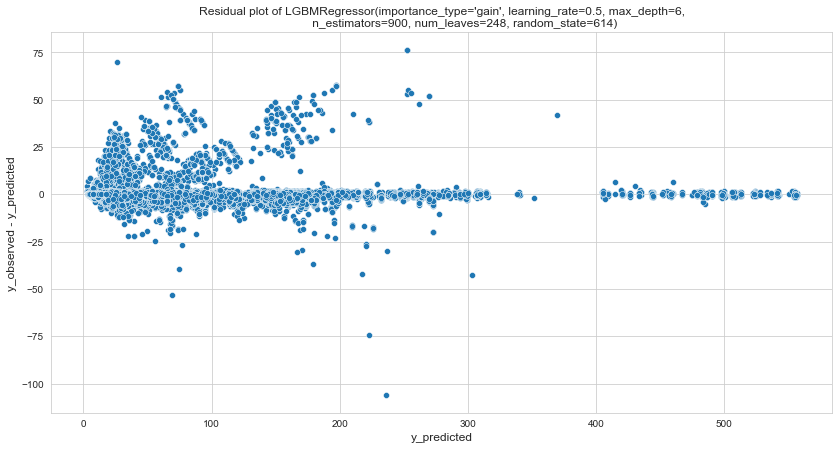

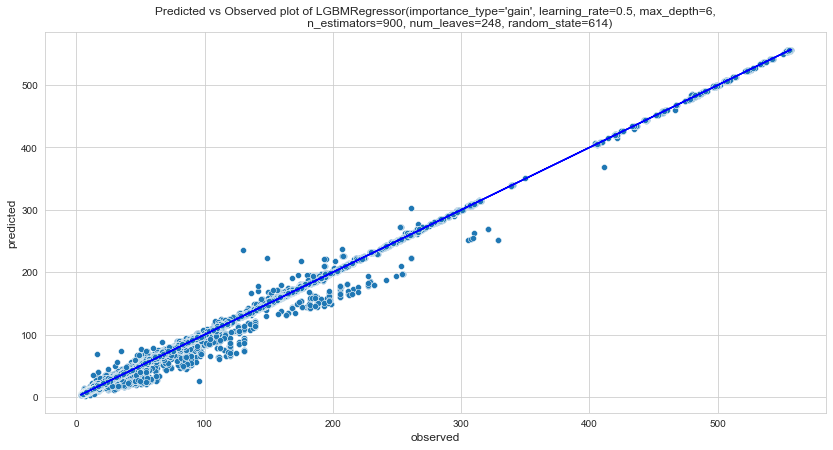

Feature Importance: bin_pcn_group: 244931252.05679387, drug_brand: 8797888.839047674, drug_name: 1219801858.0535386, diag_letter: 376269.09051067015




In [34]:
model_analysis(X_train, X_test, y_train, y_test, best_estimators, metrics)